# MIT-BIH Arrhythmia

En esta notebook, implementaremos técnicas de regularización, tales como early stopping y dropout, utilizando el [MIT-BIH Arrhythmia Database](https://physionet.org/content/mitdb/1.0.0). El objetivo principal es mejorar la generalización de nuestros modelos de aprendizaje profundo y prevenir el sobreajuste durante el entrenamiento.

## Introducción

### Objetivos

1. **Implementar y entender las técnicas de regularización** más comunes en redes neuronales, incluyendo early stopping y dropout.
2. **Entrenar modelos de clasificación** en PyTorch utilizando el MIT-BIH Arrhythmia Database.
3. **Evaluar el impacto de las técnicas de regularización** en el rendimiento del modelo utilizando métricas adecuadas.

### Contenido

1. Configuración de bibliotecas y semillas para reproducibilidad.
2. Carga y exploración del MIT-BIH Arrhythmia Database.
3. Preparación de los datos y división en conjuntos de entrenamiento y prueba.
4. Definición y entrenamiento de modelos de clasificación en PyTorch.
5. Implementación de técnicas de regularización como dropout y early stopping.
6. Evaluación y comparación del rendimiento de los modelos con y sin regularización.

### Sobre el conjunto de datos

El MIT-BIH Arrhythmia Database es un conjunto de datos ampliamente utilizado en la investigación de la arritmia cardíaca. Contiene registros de electrocardiogramas (ECG) de diferentes pacientes, con anotaciones detalladas sobre distintos tipos de arritmias. Este conjunto de datos nos permitirá entrenar modelos de clasificación capaces de identificar distintos tipos de arritmias a partir de los datos de ECG, haciendo énfasis en la importancia de la regularización para mejorar la precisión y generalización de los modelos.

El modelo esta disponible en el siguiente [link](https://www.kaggle.com/shayanfazeli/heartbeat).

In [22]:
!pip install torchinfo

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchinfo import summary

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
)

from utils import plot_taining

In [24]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [25]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cpu
Usando 4


In [59]:
NUM_WORKERS = 2

In [26]:
BATCH_SIZE = 2048  # tamaño del batch

## Carga de datos + Exploración

In [27]:
TRAIN_DATA_PATH = "data/mitbih_train.csv"
TEST_DATA_PATH = "data/mitbih_test.csv"

In [31]:
df_train = pd.read_csv(TRAIN_DATA_PATH, header=None)
df_test = pd.read_csv(TEST_DATA_PATH, header=None)

# Concatenamos los datos de entrenamiento y test
df = pd.concat([df_train, df_test], axis=0)

In [32]:
ninputs = df.shape[1] - 1
nclasses = df.iloc[:, -1].nunique()
print(f"Existen {nclasses} clases y {ninputs} características")

Existen 5 clases y 187 características


In [33]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
X_train = df_train.iloc[:, :-1]  # Extraemos las características
y_train = df_train.iloc[:, -1]  # Extraemos las etiquetas

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

In [36]:
TARGET_NAMES = [
    "Normal beat",
    "Supraventricular premature beat",
    "Premature ventricular contraction",
    "Fusion of ventricular and normal beat",
    "Unclassifiable beat",
]

### Distribución de clases

Veamos la distribución de las clases en el conjunto de datos para comprender mejor el problema de clasificación que estamos abordando.

187
0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: count, dtype: int64


<Axes: title={'center': 'Número de muestras por clase'}, xlabel='187'>

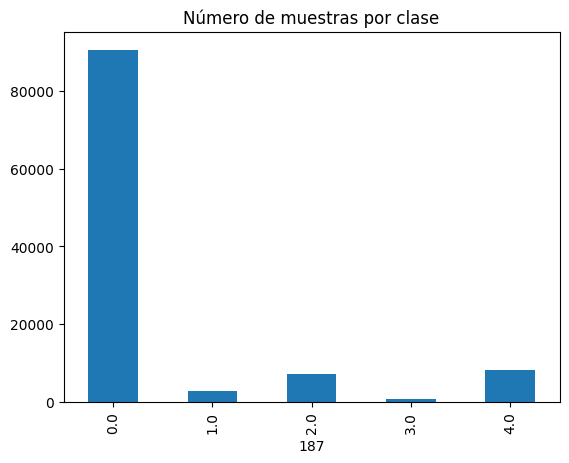

In [37]:
class_count = df.iloc[:, -1].value_counts()
print(class_count)

class_count.sort_index().plot(kind="bar", title="Número de muestras por clase")

Como se puede observar, las clases están desbalanceadas, lo que puede afectar el rendimiento de nuestro modelo. Por lo tanto, es importante tener en cuenta este desbalance al evaluar el rendimiento del modelo y considerar estrategias como el uso de pesos de clase o técnicas de aumento de datos.

## Datasets y Dataloaders

### Dataset

Vamos a crear un `Dataset` personalizado para cargar y preprocesar los datos del MIT-BIH Arrhythmia Database. Este `Dataset` se encargará de cargar los datos desde nuestros dataframe de Pandas, aplicar transformaciones, y devolver los datos en el formato adecuado para ser procesados por nuestros modelos de PyTorch.

In [38]:
class MITBIHDataSet(Dataset):
    def __init__(self, df_features, df_target, num_classes):
        self.x_df = df_features.values
        self.y_df = df_target.values
        self.num_classes = num_classes

    def __len__(self):
        return len(self.x_df)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_df[idx], dtype=torch.float32)
        y = torch.tensor(self.y_df[idx], dtype=torch.long)
        return x, y

### Split de datos

Vamos a dividir nuestro conjunto de datos en conjuntos de entrenamiento y validacion. Esta vez en vez de hacerlo con [torch.utils.data.random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) lo haremos con [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) para poder mantener el balance de clases en ambos conjuntos.

> Por lo que pudimos observar en la exploración de datos, el conjunto de prueba ya tiene un balance de clases similar al conjunto de entrenamiento.

In [39]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

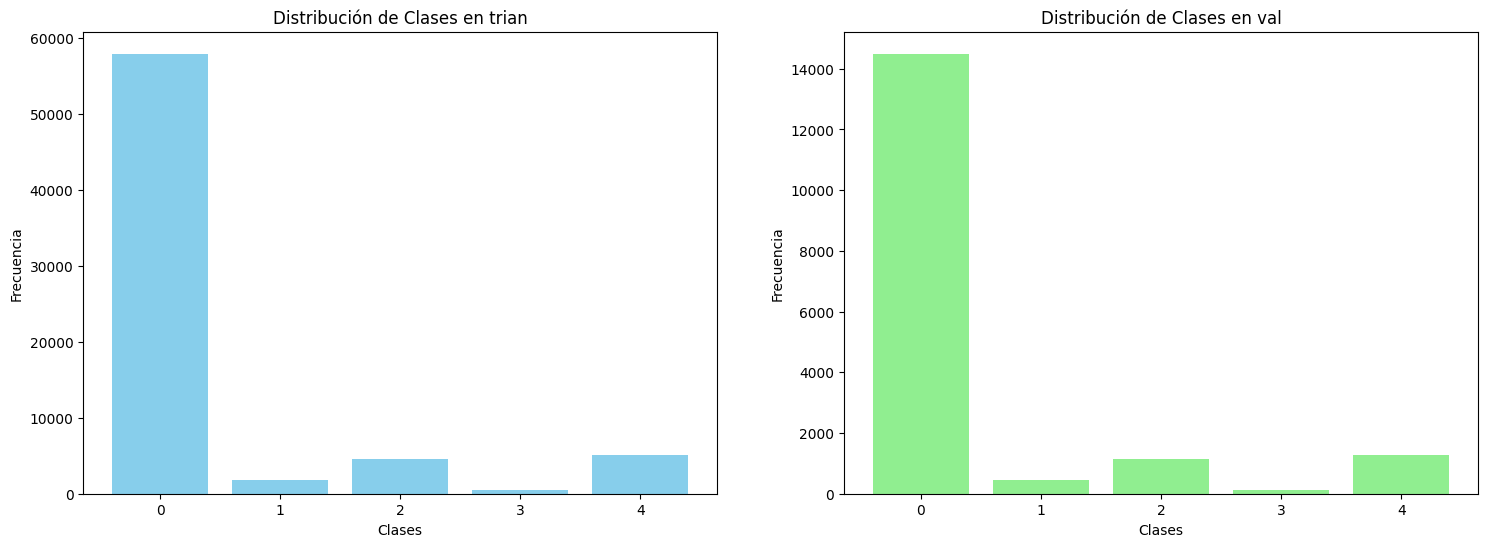

In [40]:
# Contar la frecuencia de cada clase en cada conjunto
class_counts_train = y_train.value_counts()
class_counts_val = y_val.value_counts()

# Crear subplots para los histogramas
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histograma para train
axes[0].bar(class_counts_train.index, class_counts_train.values, color="skyblue")
axes[0].set_title("Distribución de Clases en trian")
axes[0].set_xlabel("Clases")
axes[0].set_ylabel("Frecuencia")

# Histograma para val
axes[1].bar(class_counts_val.index, class_counts_val.values, color="lightgreen")
axes[1].set_title("Distribución de Clases en val")
axes[1].set_xlabel("Clases")
axes[1].set_ylabel("Frecuencia")

plt.show()

In [41]:
train_dataset = MITBIHDataSet(X_train, y_train, nclasses)
val_dataset = MITBIHDataSet(X_val, y_val, nclasses)
test_dataset = MITBIHDataSet(X_test, y_test, nclasses)

### DataLoaders

Definimos los dataloaders para cada conjunto de datos, estos son los que se encargan de cargar los datos en lotes durante el entrenamiento y la evaluación del modelo.

In [42]:
def get_data_loaders(batch_size):

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    return train_loader, val_loader, test_loader

In [49]:
train_loader, val_loader, test_loader = get_data_loaders(
    BATCH_SIZE
)  # obtenemos los dataloaders

# probamos un batch del DataLoader
x_batch, y_batch = next(iter(train_loader))
print(x_batch.shape, y_batch.shape)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([2048, 187]) torch.Size([2048])


## Definición de modelo

Empezaremos definiendo un modelo de clasificación simple en PyTorch. Este modelo constará de dos capas.

In [43]:
# MLP                                      [2048, 5]
# ├─Linear: 1-1                            [2048, 512]
# ├─Linear: 1-2                            [2048, 2048]
# ├─Linear: 1-3                            [2048, 5]

class MLP(nn.Module):
    def __init__(self, input_size, nclass):
        super(MLP, self).__init__()
        self.input = nn.Linear(input_size,512)
        self.hidden = nn.Linear(512,2048)
        self.output = nn.Linear(2048, nclass)
        self.relu = nn.ReLU()

    def forward(self, x):
        x=self.relu(self.input(x))
        x=self.relu(self.hidden(x))
        x=self.output(x)
        return x

summary(MLP(ninputs, nclasses), input_size=(BATCH_SIZE, ninputs))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [2048, 5]                 --
├─Linear: 1-1                            [2048, 512]               96,256
├─ReLU: 1-2                              [2048, 512]               --
├─Linear: 1-3                            [2048, 2048]              1,050,624
├─ReLU: 1-4                              [2048, 2048]              --
├─Linear: 1-5                            [2048, 5]                 10,245
Total params: 1,157,125
Trainable params: 1,157,125
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.37
Input size (MB): 1.53
Forward/backward pass size (MB): 42.02
Params size (MB): 4.63
Estimated Total Size (MB): 48.19

## Entrenamiento

In [45]:
def evaluate(model, criterion, data_loader, device=DEVICE):
    """
    Evalúa el modelo en los datos proporcionados y calcula la pérdida promedio.

    Args:
        model (torch.nn.Module): El modelo que se va a evaluar.
        criterion (torch.nn.Module): La función de pérdida que se utilizará para calcular la pérdida.
        data_loader (torch.utils.data.DataLoader): DataLoader que proporciona los datos de evaluación.

    Returns:
        float: La pérdida promedio en el conjunto de datos de evaluación.

    """
    model.eval()  # ponemos el modelo en modo de evaluacion
    total_loss = 0 # acumulador de la perdida
    with torch.no_grad(): # deshabilitamos el calculo de gradientes
        for x, y in data_loader: # iteramos sobre el dataloader
            x = x.to(device) # movemos los datos al dispositivo
            y = y.to(device) # movemos los datos al dispositivo
            output = model(x) # forward pass
            total_loss += criterion(output, y).item() # acumulamos la perdida
    return total_loss / len(data_loader) # retornamos la perdida promedio


def train(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    device=DEVICE,
    epochs=10,
    log_fn=None,
    log_every=1,
):
    """
    Entrena el modelo utilizando el optimizador y la función de pérdida proporcionados.

    Args:
        model (torch.nn.Module): El modelo que se va a entrenar.
        optimizer (torch.optim.Optimizer): El optimizador que se utilizará para actualizar los pesos del modelo.
        criterion (torch.nn.Module): La función de pérdida que se utilizará para calcular la pérdida.
        train_loader (torch.utils.data.DataLoader): DataLoader que proporciona los datos de entrenamiento.
        val_loader (torch.utils.data.DataLoader): DataLoader que proporciona los datos de validación.
        epochs (int): Número de épocas de entrenamiento (default: 10).
        log_fn (function): Función que se llamará después de cada log_every épocas con los argumentos (epoch, train_loss, val_loss) (default: None).
        log_every (int): Número de épocas entre cada llamada a log_fn (default: 1).

    Returns:
        Tuple[List[float], List[float]]: Una tupla con dos listas, la primera con el error de entrenamiento de cada época y la segunda con el error de validación de cada época.

    """
    epoch_train_errors = []  # colectamos el error de traing para posterior analisis
    epoch_val_errors = []  # colectamos el error de validacion para posterior analisis

    for epoch in range(epochs): # loop de entrenamiento
        model.train()  # ponemos el modelo en modo de entrenamiento
        train_loss = 0 # acumulador de la perdida de entrenamiento
        for x, y in train_loader:
            x = x.to(device) # movemos los datos al dispositivo
            y = y.to(device) # movemos los datos al dispositivo

            optimizer.zero_grad() # reseteamos los gradientes

            output = model(x) # forward pass (prediccion)
            batch_loss = criterion(output, y) # calculamos la perdida con la salida esperada

            batch_loss.backward() # backpropagation
            optimizer.step() # actualizamos los pesos

            train_loss += batch_loss.item() # acumulamos la perdida

        train_loss /= len(train_loader) # calculamos la perdida promedio de la epoca
        epoch_train_errors.append(train_loss) # guardamos la perdida de entrenamiento
        val_loss = evaluate(model, criterion, val_loader) # evaluamos el modelo en el conjunto de validacion
        epoch_val_errors.append(val_loss) # guardamos la perdida de validacion

        if log_fn is not None: # si se pasa una funcion de log
            if (epoch + 1) % log_every == 0: # loggeamos cada log_every epocas
                log_fn(epoch, train_loss, val_loss) # llamamos a la funcion de log

    return epoch_train_errors, epoch_val_errors

In [47]:
LR = 0.01
CRITERION = nn.CrossEntropyLoss().to(DEVICE)
EPOCHS = 100

In [50]:
def print_log(epoch, train_loss, val_loss):
    print(
        f"Epoch: {epoch + 1:03d}/{EPOCHS:03d} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}"
    )

base_model = MLP(ninputs, nclasses).to(DEVICE)

optimizer = optim.Adam(base_model.parameters(), lr=LR)

epoch_train_errors, epoch_val_errors = train(
    base_model,
    optimizer,
    CRITERION,
    train_loader,
    val_loader,
    DEVICE,
    EPOCHS,
    print_log,
    5,
)

Epoch: 005/100 | Train Loss: 0.16571 | Val Loss: 0.17790
Epoch: 010/100 | Train Loss: 0.11197 | Val Loss: 0.11796
Epoch: 015/100 | Train Loss: 0.09405 | Val Loss: 0.12045
Epoch: 020/100 | Train Loss: 0.07474 | Val Loss: 0.09208
Epoch: 025/100 | Train Loss: 0.07312 | Val Loss: 0.11282
Epoch: 030/100 | Train Loss: 0.05809 | Val Loss: 0.07767
Epoch: 035/100 | Train Loss: 0.05658 | Val Loss: 0.09448
Epoch: 040/100 | Train Loss: 0.05101 | Val Loss: 0.08840
Epoch: 045/100 | Train Loss: 0.04853 | Val Loss: 0.08441
Epoch: 050/100 | Train Loss: 0.04596 | Val Loss: 0.08522
Epoch: 055/100 | Train Loss: 0.04821 | Val Loss: 0.09251
Epoch: 060/100 | Train Loss: 0.03140 | Val Loss: 0.08143
Epoch: 065/100 | Train Loss: 0.03361 | Val Loss: 0.09070
Epoch: 070/100 | Train Loss: 0.02822 | Val Loss: 0.08713
Epoch: 075/100 | Train Loss: 0.04136 | Val Loss: 0.11587
Epoch: 080/100 | Train Loss: 0.02476 | Val Loss: 0.10237
Epoch: 085/100 | Train Loss: 0.02238 | Val Loss: 0.10114
Epoch: 090/100 | Train Loss: 0.

## Loss durante el entrenamiento

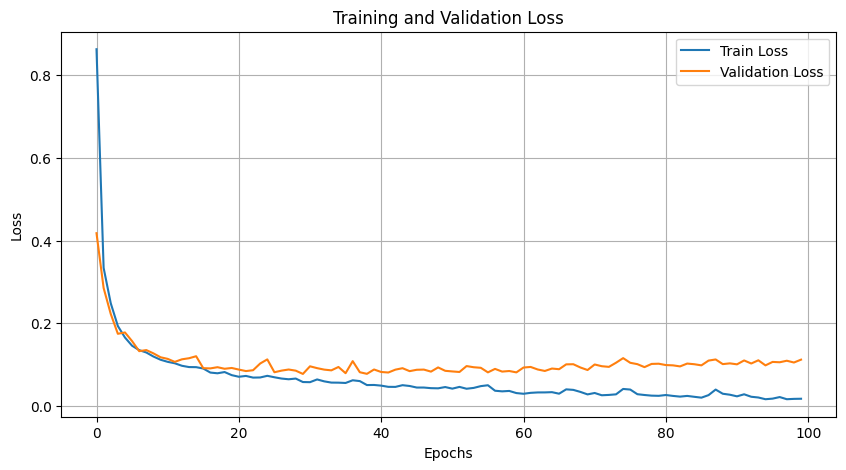

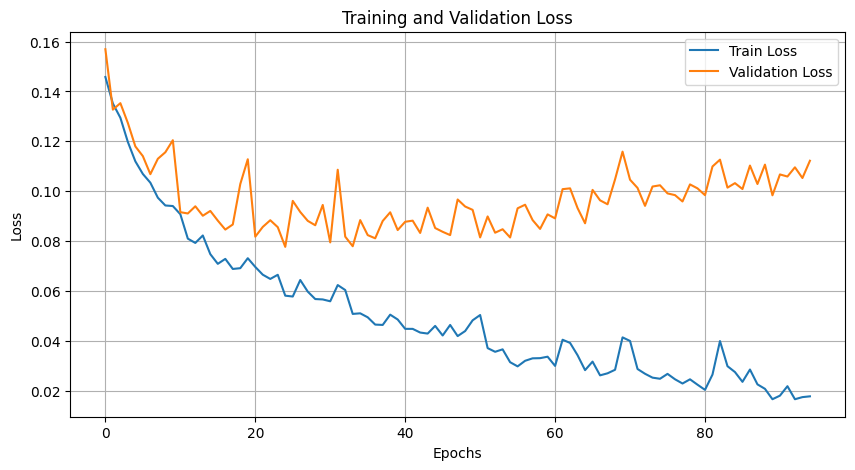

In [51]:
# graficamos los errores de entrenamiento y validación
plot_taining(epoch_train_errors, epoch_val_errors)
# graficamos los errores de entrenamiento y validación a partir de la época 5
plot_taining(epoch_train_errors[5:], epoch_val_errors[5:])

## Evaluación

Vamos a evaluar el rendimiento de nuestro modelo en el conjunto de prueba utilizando métricas como la precisión, el recall y la matriz de confusión.

In [52]:
def model_classification_report(model, dataloader):
    # Evaluación del modelo
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
      for x,y in dataloader:
          x = x.to(DEVICE)
          #y = y.to(DEVICE)
          all_labels.extend(y.cpu().numpy())
          output = model(x)
          pred = torch.argmax(output, dim=1)
          all_preds.extend(pred.cpu().numpy())


    # Calcular precisión (accuracy)
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}\n")

    # Reporte de clasificación
    report = classification_report(
        all_labels, all_preds, target_names=TARGET_NAMES
    )
    print("Reporte de clasificación:\n", report)

In [53]:
model_classification_report(base_model, test_loader)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy: 0.9763

Reporte de clasificación:
                                        precision    recall  f1-score   support

                          Normal beat       0.98      0.99      0.99     18118
      Supraventricular premature beat       0.79      0.73      0.76       556
    Premature ventricular contraction       0.94      0.93      0.94      1448
Fusion of ventricular and normal beat       0.88      0.67      0.76       162
                  Unclassifiable beat       0.98      0.97      0.98      1608

                             accuracy                           0.98     21892
                            macro avg       0.92      0.86      0.88     21892
                         weighted avg       0.98      0.98      0.98     21892



**Métricas por Clase**
- **Precision:** De lo que predije como esta clase, ¿cuánto acerté? (↑ = menos falsos positivos)
  - `Precision = TP / (TP + FP)`
- **Recall:** De todos los casos reales, ¿cuántos detecté? (↑ = menos falsos negativos)  
  - `Recall = TP / (TP + FN)`
- **F1-Score:** Balance entre precision y recall (media armónica)
  - `F1 = 2 * (Precision * Recall) / (Precision + Recall)`
- **Support:** Cantidad de muestras reales de esa clase

**Métricas Globales**
- **Accuracy:** % total de aciertos `(TP + TN) / Total`
- **Macro Avg:** Promedio simple (todas las clases pesan igual)
- **Weighted Avg:** Promedio ponderado por support (refleja desbalance)

**Interpretación Rápida**
- Valores → 1.0 = Mejor | Valores → 0.0 = Peor
- Precision > Recall = Modelo conservador
- Recall > Precision = Modelo agresivo  
- Macro < Weighted = Mejor en clases mayoritarias
- Support desigual = Dataset desbalanceado

> **Donde:** TP = True Positives, FP = False Positives, FN = False Negatives, TN = True Negatives

## Ejercicios

1. **Implementar dropout**: Agregar más capas lineales al modelo y aplicar dropout después de cada capa. Evaluar el impacto de dropout en el rendimiento del modelo.

2. **Implementar early stopping**: Implementar la técnica de early stopping para detener el entrenamiento cuando el rendimiento del modelo deja de mejorar en el conjunto de validación. Evaluar el impacto de early stopping en el rendimiento del modelo.

3. **Implementar label smoothing**: Implementar la técnica de label smoothing para mejorar la generalización del modelo. Evaluar el impacto de label smoothing en el rendimiento del modelo.

4. **Modelo libre**: Implementar un modelo de clasificación en PyTorch utilizando el MIT-BIH Arrhythmia Database. Experimentar con diferentes arquitecturas de modelos, hiperparámetros y técnicas de regularización para mejorar el rendimiento del modelo.

5. **Comparación de modelos**: Con cuál de los modelos te quedarías si:
    - Tuvieras que elegir el modelo con mejor precisión en promedio.
    - Tuvieras que elegir el modelo con mejor recall en promedio.
    - Tuvieras que elegir el modelo con mejor F1-score en promedio.

### Ejericio 1: Implementar dropout

[Dropout](https://jmlr.org/papers/v15/srivastava14a.html) es una técnica de regularización utilizada en redes neuronales para prevenir el sobreajuste (overfitting). Consiste en desactivar aleatoriamente un subconjunto de neuronas durante el entrenamiento en cada paso de propagación hacia adelante. Esto ayuda a la red a no depender demasiado de ninguna neurona en particular, promoviendo una representación más robusta y generalizable de los datos.

**¿Cómo Funciona Dropout?**

Durante el entrenamiento, Dropout:
1. **Apagado Aleatorio de Neuronas**: Un porcentaje de neuronas se apaga aleatoriamente en cada iteración.
2. **Escalado de Neuronas Activas**: Las activaciones de las neuronas restantes se escalan para mantener el equilibrio en la red.

**Evaluación y Dropout**

Durante la evaluación, es crucial que las capas Dropout se comporten de manera diferente:
- **Entrenamiento (`model.train()`)**: Dropout está activo, apagando neuronas y escalando las activaciones.
- **Evaluación (`model.eval()`)**: Dropout está desactivado, permitiendo que todas las neuronas estén activas sin escalado de activaciones. Esto asegura que el modelo utilice toda su capacidad para hacer predicciones.

**Implementación de Dropout en PyTorch**

En PyTorch, podemos implementar Dropout utilizando la capa [`torch.nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html). Esta capa apaga aleatoriamente un porcentaje de neuronas durante el entrenamiento y escala las activaciones durante la evaluación.

In [54]:
rand_torch = torch.rand((2,5)) # genero datos al azar
print(rand_torch) # imprimimos sus valores
drop_layer = nn.Dropout(0.5) # creamos una capa de dropout con un 50% de apagar una neurona

tensor([[0.8956, 0.9687, 0.4786, 0.2102, 0.9144],
        [0.9747, 0.8469, 0.9311, 0.6691, 0.2716]])


In [55]:
drop_layer.train() # por defecto ya esta en train mode
print(drop_layer(rand_torch)) # 1) apaga (pone en 0) con una probablidad p definida en la capa 2) pondera los valores restantes proporcionalmente

tensor([[1.7911, 0.0000, 0.9573, 0.4204, 1.8288],
        [0.0000, 1.6939, 1.8621, 1.3383, 0.0000]])


In [56]:
drop_layer.eval() # al ponerlo en eval no deberia surtir efecto al pasar por la capa
print(drop_layer(rand_torch))

tensor([[0.8956, 0.9687, 0.4786, 0.2102, 0.9144],
        [0.9747, 0.8469, 0.9311, 0.6691, 0.2716]])


Algunas reglas prácticas para usar Dropout de manera efectiva:

- **Ubicación: "Después de Activación, Nunca en Output"**
```python
x = F.relu(self.fc(x))
x = self.dropout(x)  # ✅ Después de activación
# ❌ NUNCA dropout en la capa final
```

- **Valores: "20-50 Rule"**
```python
dropout = nn.Dropout(0.5)    # Capas ocultas (default)
dropout = nn.Dropout(0.2)    # CNNs, RNNs, entrada
# Si dudas → usa 0.3
```

- **Train/Eval: "Siempre Cambia Modo"**
```python
model.train()   # Entrenamiento
model.eval()    # ⚠️ CRÍTICO para inferencia
```

- **Cuándo Usar: "Solo si Overfittea"**
```python
# train_acc=99%, val_acc=85% → Agrega dropout
# train_acc=80%, val_acc=78% → No necesitas
# Empieza sin dropout, agrega si necesitas
```

- **Arquitectura: "Más Profundo = Menos Dropout"**
```python
# 2-3 capas:  p=0.5
# 5-10 capas: p=0.2-0.3  
# 10+ capas:  p=0.1 o nada
```

In [61]:
class MLP_EJ1(nn.Module):
    def __init__(self, input_size, nclass, dropout=0.5):
        super(MLP_EJ1, self).__init__()
        self.input = nn.Linear(input_size,512)
        self.hidden = nn.Linear(512,2048)
        self.output = nn.Linear(2048, nclass)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.relu(self.input(x))
        x = self.dropout(x)
        x = self.relu(self.hidden(x))
        x = self.dropout(x)
        x = self.output(x)
        return x

summary(MLP_EJ1(ninputs, nclasses), input_size=(BATCH_SIZE, ninputs))

Layer (type:depth-idx)                   Output Shape              Param #
MLP_EJ1                                  [2048, 5]                 --
├─Linear: 1-1                            [2048, 512]               96,256
├─ReLU: 1-2                              [2048, 512]               --
├─Dropout: 1-3                           [2048, 512]               --
├─Linear: 1-4                            [2048, 2048]              1,050,624
├─ReLU: 1-5                              [2048, 2048]              --
├─Dropout: 1-6                           [2048, 2048]              --
├─Linear: 1-7                            [2048, 5]                 10,245
Total params: 1,157,125
Trainable params: 1,157,125
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.37
Input size (MB): 1.53
Forward/backward pass size (MB): 42.02
Params size (MB): 4.63
Estimated Total Size (MB): 48.19

Algunas preguntas para pensar:
- ¿Por qué dropout no tiene parametros entrenables?
- ¿Qué pasaría si no ponemos el modelo en eval mode durante la evaluación?

In [62]:
ej1_model = MLP_EJ1(ninputs, nclasses, 0.2).to(DEVICE)

optimizer = optim.Adam(ej1_model.parameters(), lr=LR)

epoch_train_errors, epoch_val_errors = train(
    ej1_model,
    optimizer,
    CRITERION,
    train_loader,
    val_loader,
    DEVICE,
    EPOCHS,
    print_log,
    5,
)

Epoch: 005/100 | Train Loss: 0.31070 | Val Loss: 0.25807
Epoch: 010/100 | Train Loss: 0.26629 | Val Loss: 0.23344
Epoch: 015/100 | Train Loss: 0.24485 | Val Loss: 0.21062
Epoch: 020/100 | Train Loss: 0.22798 | Val Loss: 0.19011
Epoch: 025/100 | Train Loss: 0.21048 | Val Loss: 0.16869
Epoch: 030/100 | Train Loss: 0.19789 | Val Loss: 0.15977
Epoch: 035/100 | Train Loss: 0.18950 | Val Loss: 0.14574
Epoch: 040/100 | Train Loss: 0.18476 | Val Loss: 0.15767
Epoch: 045/100 | Train Loss: 0.17663 | Val Loss: 0.15685
Epoch: 050/100 | Train Loss: 0.17347 | Val Loss: 0.14420
Epoch: 055/100 | Train Loss: 0.16946 | Val Loss: 0.13692
Epoch: 060/100 | Train Loss: 0.16727 | Val Loss: 0.15294
Epoch: 065/100 | Train Loss: 0.17380 | Val Loss: 0.14337
Epoch: 070/100 | Train Loss: 0.16416 | Val Loss: 0.13760
Epoch: 075/100 | Train Loss: 0.16460 | Val Loss: 0.13379
Epoch: 080/100 | Train Loss: 0.16077 | Val Loss: 0.13064
Epoch: 085/100 | Train Loss: 0.16066 | Val Loss: 0.12989
Epoch: 090/100 | Train Loss: 0.

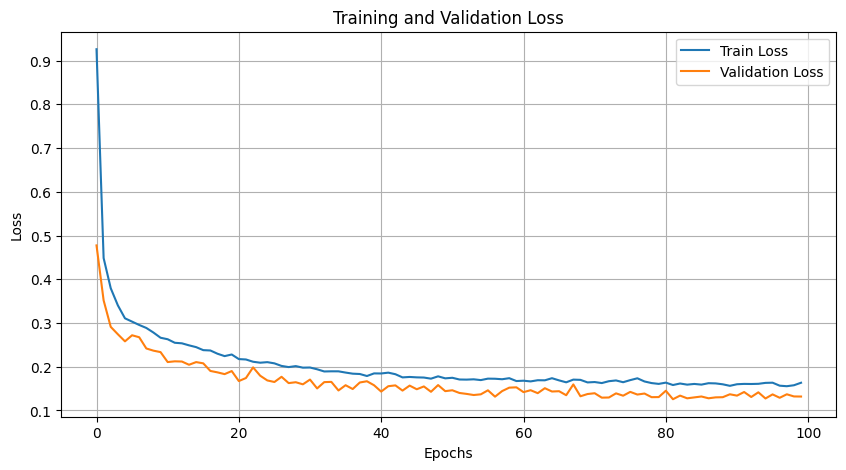

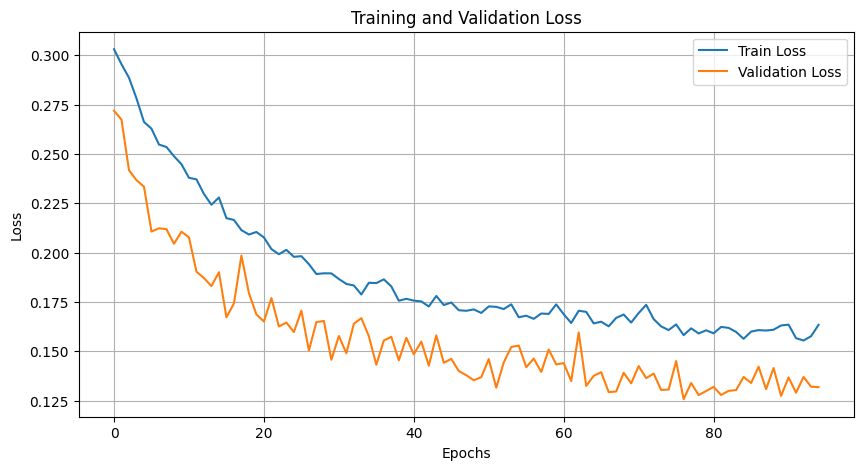

In [63]:
# graficamos los errores de entrenamiento y validación
plot_taining(epoch_train_errors, epoch_val_errors)
# graficamos los errores de entrenamiento y validación a partir de la época 5
plot_taining(epoch_train_errors[5:], epoch_val_errors[5:])

In [64]:
model_classification_report(ej1_model, test_loader)

Accuracy: 0.9623

Reporte de clasificación:
                                        precision    recall  f1-score   support

                          Normal beat       0.97      0.99      0.98     18118
      Supraventricular premature beat       0.90      0.52      0.66       556
    Premature ventricular contraction       0.90      0.83      0.86      1448
Fusion of ventricular and normal beat       0.73      0.57      0.64       162
                  Unclassifiable beat       0.98      0.93      0.96      1608

                             accuracy                           0.96     21892
                            macro avg       0.89      0.77      0.82     21892
                         weighted avg       0.96      0.96      0.96     21892



- ¿Cómo se compara el resultado con el modelo sin dropout?

#### Lectura Adicional
- [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://jmlr.org/papers/v15/srivastava14a.html) - Paper original de Dropout
- [Deep Learning Book - Regularization](https://www.deeplearningbook.org/contents/regularization.html)
- [Dive into Deep Learning - Dropout](https://d2l.ai/chapter_multilayer-perceptrons/dropout.html)

### Ejercicio 2: Implementar early stopping

[Early stopping](https://en.wikipedia.org/wiki/Early_stopping) es una técnica de regularización utilizada para prevenir el sobreajuste en modelos de aprendizaje profundo. Consiste en detener el entrenamiento del modelo cuando el rendimiento en el conjunto de validación deja de mejorar, evitando así que el modelo se ajuste demasiado a los datos de entrenamiento.

**¿Cómo Funciona Early Stopping?**

Early stopping se basa en el principio de que, a medida que el modelo se entrena, el rendimiento en el conjunto de validación debería mejorar hasta cierto punto y luego comenzar a empeorar. Esto se debe a que el modelo se ajusta cada vez más a los datos de entrenamiento, lo que puede llevar a un sobreajuste. Early stopping busca detener el entrenamiento en el punto óptimo, antes de que el modelo comience a sobreajustarse.

In [72]:
class EarlyStopping:
    def __init__(self, patience=5):
        """
        Args:
            patience (int): Cuántas épocas esperar después de la última mejora.
        """
        self.patience = patience
        self.without_imp = 0
        self.best_score = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_score:
            self.best_score = val_loss
            self.without_imp = 0
        else:
            self.without_imp += 1
            if self.without_imp >= self.patience:
                self.early_stop = True

Nuestra clase `EarlyStopping` implementa la lógica de early stopping muy sencilla. Guarda la mejor loss de validación vista hasta el momento y detiene el entrenamiento si la loss de validación no mejora después de un cierto número de épocas.

In [73]:
# lo ponemos a prueba con un ejemplo sencillo
early_stopping = EarlyStopping(patience=2)
loss_simulated = [0.1, 0.09, 0.08, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]

for i, loss in enumerate(loss_simulated):
    early_stopping(loss)
    if early_stopping.early_stop:
        print(
            f"Detener entrenamiento en la época {i + 1}, la mejor pérdida fue {early_stopping.best_score}"
        )
        break

Detener entrenamiento en la época 5, la mejor pérdida fue 0.08


Vamos a redefinir nuestro training loop para incluir la lógica de early stopping.

In [75]:
def train_es(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    device,
    patience=5,
    epochs=10,
    log_fn=None,
    log_every=1,
):
    """
    Entrena el modelo utilizando el optimizador y la función de pérdida proporcionados.

    Args:
        model (torch.nn.Module): El modelo que se va a entrenar.
        optimizer (torch.optim.Optimizer): El optimizador que se utilizará para actualizar los pesos del modelo.
        criterion (torch.nn.Module): La función de pérdida que se utilizará para calcular la pérdida.
        train_loader (torch.utils.data.DataLoader): DataLoader que proporciona los datos de entrenamiento.
        val_loader (torch.utils.data.DataLoader): DataLoader que proporciona los datos de validación.
        device (str): El dispositivo donde se ejecutará el entrenamiento.
        patience (int): Número de épocas a esperar después de la última mejora en val_loss antes de detener el entrenamiento (default: 5).
        epochs (int): Número de épocas de entrenamiento (default: 10).
        log_fn (function): Función que se llamará después de cada log_every épocas con los argumentos (epoch, train_loss, val_loss) (default: None).
        log_every (int): Número de épocas entre cada llamada a log_fn (default: 1).

    Returns:
        Tuple[List[float], List[float]]: Una tupla con dos listas, la primera con el error de entrenamiento de cada época y la segunda con el error de validación de cada época.

    """

    epoch_train_errors = []  # colectamos el error de traing para posterior analisis
    epoch_val_errors = []  # colectamos el error de validacion para posterior analisis
    early_stopping = EarlyStopping(patience)

    for epoch in range(epochs): # loop de entrenamiento
        model.train()  # ponemos el modelo en modo de entrenamiento
        train_loss = 0 # acumulador de la perdida de entrenamiento
        for x, y in train_loader:
            x = x.to(device) # movemos los datos al dispositivo
            y = y.to(device) # movemos los datos al dispositivo

            optimizer.zero_grad() # reseteamos los gradientes

            output = model(x) # forward pass (prediccion)
            batch_loss = criterion(output, y) # calculamos la perdida con la salida esperada

            batch_loss.backward() # backpropagation
            optimizer.step() # actualizamos los pesos

            train_loss += batch_loss.item() # acumulamos la perdida

        train_loss /= len(train_loader) # calculamos la perdida promedio de la epoca
        epoch_train_errors.append(train_loss) # guardamos la perdida de entrenamiento
        val_loss = evaluate(model, criterion, val_loader) # evaluamos el modelo en el conjunto de validacion
        epoch_val_errors.append(val_loss) # guardamos la perdida de validacion
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(
                f"Detener entrenamiento en la época {epoch + 1}, la mejor pérdida fue {early_stopping.best_score}"
            )
            break

        if log_fn is not None: # si se pasa una funcion de log
            if (epoch + 1) % log_every == 0: # loggeamos cada log_every epocas
                log_fn(epoch, train_loss, val_loss) # llamamos a la funcion de log

    return epoch_train_errors, epoch_val_errors


In [76]:
ej2_model = MLP(ninputs, nclasses).to(DEVICE)

optimizer = optim.Adam(ej2_model.parameters(), lr=LR)

epoch_train_errors, epoch_val_errors = train_es(
    ej2_model,
    optimizer,
    CRITERION,
    train_loader,
    val_loader,
    DEVICE,
    3,
    EPOCHS,
    print_log,
    5,
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 005/100 | Train Loss: 0.16253 | Val Loss: 0.16655
Epoch: 010/100 | Train Loss: 0.10509 | Val Loss: 0.11189
Epoch: 015/100 | Train Loss: 0.08475 | Val Loss: 0.10837
Epoch: 020/100 | Train Loss: 0.07915 | Val Loss: 0.12237
Detener entrenamiento en la época 25, la mejor pérdida fue 0.07829981297254562


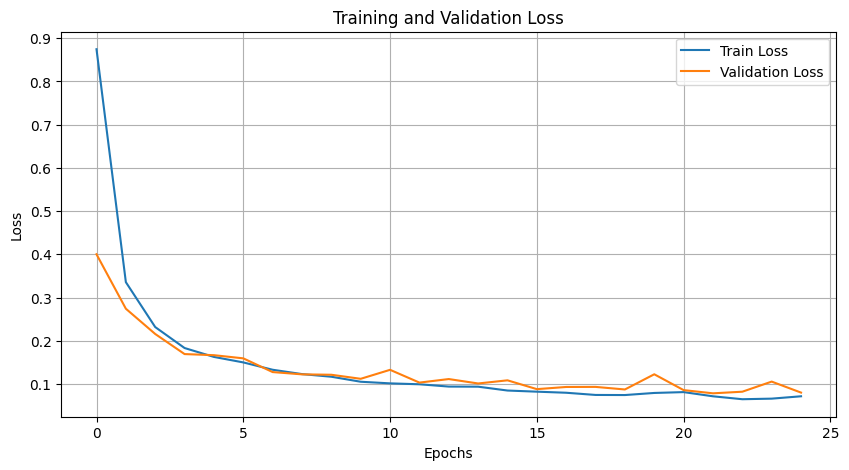

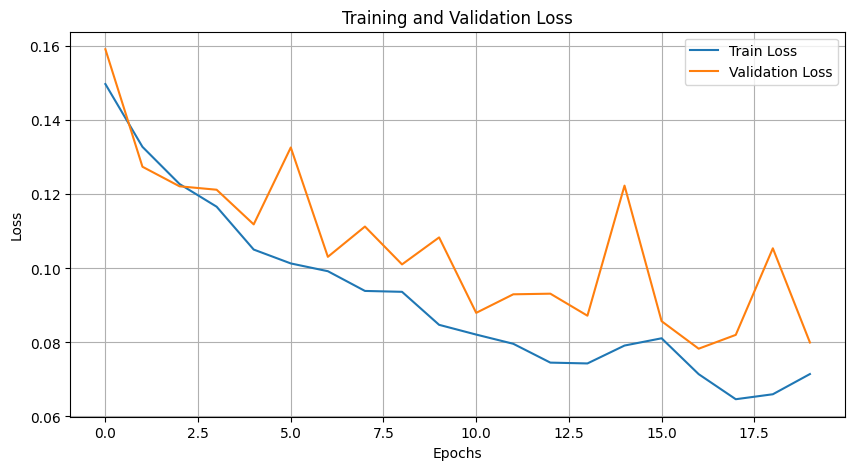

In [77]:
# graficamos los errores de entrenamiento y validación
plot_taining(epoch_train_errors, epoch_val_errors)
# graficamos los errores de entrenamiento y validación a partir de la época 5
plot_taining(epoch_train_errors[5:], epoch_val_errors[5:])

In [78]:
model_classification_report(ej2_model, test_loader)

Accuracy: 0.9751

Reporte de clasificación:
                                        precision    recall  f1-score   support

                          Normal beat       0.98      0.99      0.99     18118
      Supraventricular premature beat       0.94      0.61      0.74       556
    Premature ventricular contraction       0.93      0.92      0.92      1448
Fusion of ventricular and normal beat       0.88      0.59      0.70       162
                  Unclassifiable beat       0.98      0.97      0.97      1608

                             accuracy                           0.98     21892
                            macro avg       0.94      0.82      0.87     21892
                         weighted avg       0.97      0.98      0.97     21892



#### Lectura Adicional
- "Other than the obvious difference with the previous study (this used real data), it is
important to note another significant point: in this case. we stopped iterating (by anyone
particular criterion) when that criterion was leading to no new test set performance
improvement" - From: [Generalization and Parameter Estimation in Feedforward Nets: Some Experiments](https://proceedings.neurips.cc/paper/1989/file/63923f49e5241343aa7acb6a06a751e7-Paper.pdf)
- [Deep Learning Book - Regularization](https://www.deeplearningbook.org/contents/regularization.html)
- [Dive into Deep Learning - Early Stopping](https://d2l.ai/chapter_multilayer-perceptrons/generalization-deep.html#early-stopping)

### Ejercicio 3: Implementar label smoothing

[Label smoothing](https://towardsdatascience.com/what-is-label-smoothing-108debd7ef06) es una técnica de regularización utilizada en el entrenamiento de modelos de clasificación para mejorar la generalización y evitar que el modelo se vuelva demasiado confiado en sus predicciones. Consiste en suavizar las etiquetas de clase, en lugar de asignar una probabilidad de 1 a la clase correcta y 0 a las demás, se asigna una probabilidad ligeramente menor a la clase correcta y una probabilidad ligeramente mayor a las demás clases.

Se pude aplicar con la siguiente formula:

$$ y_{ls} = (1 - \alpha) \cdot y_{hot} + \frac{\alpha}{K} $$

donde:
- $y_{ls}$ son las etiquetas suavizadas.
- $y_{hot}$ son las etiquetas originales en formato one-hot.
- $\alpha$ es el factor de suavizado (entre 0 y 1).
- $K$ es el número de clases.

In [79]:
# Ejemplo de etiquetas (índices de clase)
z = torch.tensor([0, 1, 2, 1, 3, 2])  # Etiquetas de ejemplo
print(f"Etiquetas\n{z}")

# Convertir a one-hot encoding
z_one_hot = F.one_hot(z, nclasses)
print(f"\nOne-hot encoding\n{z_one_hot}")

# Parámetro de suavizado
alpha = 0.1  # Factor de suavizado
K = nclasses

# Aplicar label smoothing
z_ls = (1 - alpha) * z_one_hot + alpha / K
print(f"\nLabel smoothing\n{z_ls}")

Etiquetas
tensor([0, 1, 2, 1, 3, 2])

One-hot encoding
tensor([[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0]])

Label smoothing
tensor([[0.9200, 0.0200, 0.0200, 0.0200, 0.0200],
        [0.0200, 0.9200, 0.0200, 0.0200, 0.0200],
        [0.0200, 0.0200, 0.9200, 0.0200, 0.0200],
        [0.0200, 0.9200, 0.0200, 0.0200, 0.0200],
        [0.0200, 0.0200, 0.0200, 0.9200, 0.0200],
        [0.0200, 0.0200, 0.9200, 0.0200, 0.0200]])


Afortunadamente, PyTorch proporciona una implementación de label smoothing en la función de pérdida [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) a través del parámetro `label_smoothing`. Al establecer `label_smoothing` en un valor mayor que cero, se aplica label smoothing a la función de pérdida.

In [80]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1).to(DEVICE)

In [ ]:
ej3_model = MLP(ninputs, nclasses).to(DEVICE)

optimizer = optim.Adam(ej3_model.parameters(), lr=LR)

epoch_train_errors, epoch_val_errors = train(
    ej3_model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    DEVICE,
    EPOCHS,
    print_log,
    5,
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 005/100 | Train Loss: 0.62371 | Val Loss: 0.62105
Epoch: 010/100 | Train Loss: 0.59409 | Val Loss: 0.58865
Epoch: 015/100 | Train Loss: 0.56829 | Val Loss: 0.57571
Epoch: 020/100 | Train Loss: 0.53593 | Val Loss: 0.53591


In [ ]:
model_classification_report(ej3_model, test_loader)